Be careful about the virtual environments. Indeed, there are different algorithms, in this notebook, in the different sections and we different dependencies.   
You many not be able to run the full notebook with the same virtual env !

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import sys
import imp
from metrics import *
import cv2
import time
import glob

In [3]:
data_folder = './tiny/data/widerface/WIDER_val/images/'

## Loading Ground Truth

In [3]:
with open('./tiny/data/widerface/wider_face_val_bbx_gt.txt') as f:
    annotation_file = [k.strip() for k in f.readlines()]
    
image_name = [k for k in annotation_file if '--' in k]
d = {} 
# d[name] = [(x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose)]
for name in image_name:
    n_index = annotation_file.index(name)
    n_pictures = int(annotation_file[n_index+1])
    d[name] = annotation_file[n_index+2:n_index+2+n_pictures]

## MXNet 
Using MXNet (Apache scalable deep learning library) for face-related algorithm, **Faster-RCNN** and **ResNet-50** (not optimized, see https://arxiv.org/pdf/1706.01061.pdf for an improved Faster R-CNN for Faces)  
Virtual Env : `source ~/Work/mxnet/bin/activate`  
**!! Use MXNet Kernel !! **

In [4]:
sys.path.append('mxnet-face/detection/')
import detecter
imp.reload(detecter)

<module 'detecter' from 'mxnet-face/detection/detecter.py'>

#### Single Metric

In [59]:
data_dir = glob.glob(data_folder+'*')[10] + '/'
img_path = glob.glob(data_dir + '*')[0]
img = cv2.imread(img_path)
_, scale = detecter.resize(img.copy(), 600, 1000)
_, dets = detecter.main(img_path)
for i in range(dets.shape[0]):
    bbox = dets[i, :4]
    cv2.rectangle(img, (int(round(bbox[0]/scale)), int(round(bbox[1]/scale))),
                  (int(round(bbox[2]/scale)), int(round(bbox[3]/scale))),  (0, 0, 255), 2)

time cost is:2.191373825073242s


In [60]:
bb = [(int(round(dets[i, 0]/scale)), int(round(dets[i, 1]/scale)),
      int(round(dets[i, 2]/scale)), int(round(dets[i, 3]/scale)))  for i in range(dets.shape[0])]

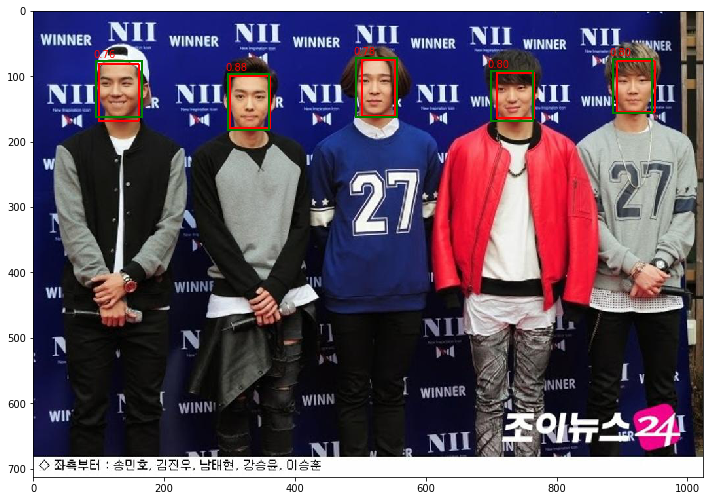

In [61]:
f, ax = plt.subplots(figsize=(10,10))
ax.imshow(img[:,:,::-1])
for k in d[img_path.replace(data_folder, '')]:
    _, jd = find_best_bbox(k, bb)
    (x1, y1, w, h, _, _, _, _, _, _) = map(int, k.split())
    rect = patches.Rectangle((x1,y1),w, h,linewidth=2,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    ax.text(x1-5, y1-5, '%.2f' % jd, color='r')

#### One folder metrics

In [5]:
data_dir = glob.glob(data_folder+'*')[40] + '/'
b = []
tic = time.time()
for img_path in glob.glob(data_dir + '*'):
    img = cv2.imread(img_path)
    _, scale = detecter.resize(img.copy(), 600, 1000)
    _, dets = detecter.main(img_path)
    bb = [(int(round(dets[i, 0]/scale)), int(round(dets[i, 1]/scale)),
          int(round(dets[i, 2]/scale)), int(round(dets[i, 3]/scale)))  for i in range(dets.shape[0])]
    b.append(bb)
toc = time.time()
print('It took %d sec' % (toc-tic))

It took 261 sec


In [6]:
a, df = compute_stats(data_dir, d, b)
#df.mJaccard = df.mJaccard.fillna(0)

In [92]:
df.head()

,mJaccard,Nb_Truth_Bboxes,Nb_Pred_Bboxes,Ratio_Bboxes,Folder
0,0.693252,18.0,4.0,0.222222,0--Parade/
1,0.760068,17.0,12.0,0.705882,0--Parade/
2,0.764574,11.0,7.0,0.636364,0--Parade/
3,0.605266,9.0,2.0,0.222222,0--Parade/
4,0.000000,317.0,0.0,0.000000,0--Parade/


In [7]:
print('%d/%d (%.2f) bounding boxes found over all images of the folder\n\
Mean Jaccard : %.2f' % (df.Nb_Pred_Bboxes.sum(),
       df.Nb_Truth_Bboxes.sum(), df.Nb_Pred_Bboxes.sum() / df.Nb_Truth_Bboxes.sum(),
       df.mJaccard.mean()))

392/3948 (0.10) bounding boxes found over all images of the folder
Mean Jaccard : 0.74


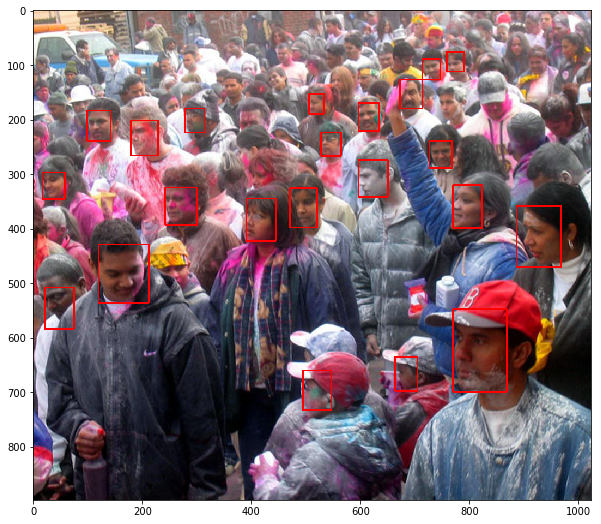

In [8]:
idx = 92
img = cv2.imread(glob.glob(data_dir + '*')[idx])
for i in range(len(b[idx])):
    bbox = b[idx][i]
    cv2.rectangle(img, (bbox[0], bbox[1]),
                  (bbox[2], bbox[3]),  (0, 0, 255), 2)
f, ax = plt.subplots(figsize=(10,10))
ax.imshow(img[:,:,::-1])

## Tiny Faces
**!! Use TensorFlow Kernel !! **

In [32]:
import tensorflow as tf
sys.path.append('./Tiny_Faces_in_Tensorflow/')
import evaluate
import tiny_face_eval as tiny
weights_path = './Tiny_Faces_in_Tensorflow/hr_res101.pkl'

In [51]:
imp.reload(evaluate)
imp.reload(tiny)

<module 'tiny_face_eval' from './Tiny_Faces_in_Tensorflow/tiny_face_eval.py'>

In [52]:
data_dir = glob.glob(data_folder+'*')[40] + '/'
weights_path = './Tiny_Faces_in_Tensorflow/hr_res101.pkl'
tic = time.time()
with tf.Graph().as_default():
    b = evaluate.evaluate(weight_file_path=weights_path, data_dir=data_dir)
toc = time.time()
print('It took %d sec' % (toc-tic))

It took 72 sec


In [42]:
a, df = compute_stats(data_dir, d, b)

In [43]:
df.head()

,mJaccard,Nb_Truth_Bboxes,Nb_Pred_Bboxes,Ratio_Bboxes,Folder
0,0.728720,18.0,14.0,0.777778,0--Parade/
1,0.838189,17.0,16.0,0.941176,0--Parade/
2,0.794534,11.0,11.0,1.000000,0--Parade/
3,0.642058,9.0,8.0,0.888889,0--Parade/
4,0.744350,317.0,179.0,0.564669,0--Parade/


In [44]:
print('%d/%d (%.2f) bounding boxes found over all images of the folder\n\
Mean Jaccard : %.2f' % (df.Nb_Pred_Bboxes.sum(),
       df.Nb_Truth_Bboxes.sum(), df.Nb_Pred_Bboxes.sum() / df.Nb_Truth_Bboxes.sum(),
       df.mJaccard.mean()))

2929/3948 (0.74) bounding boxes found over all images of the folder
Mean Jaccard : 0.75


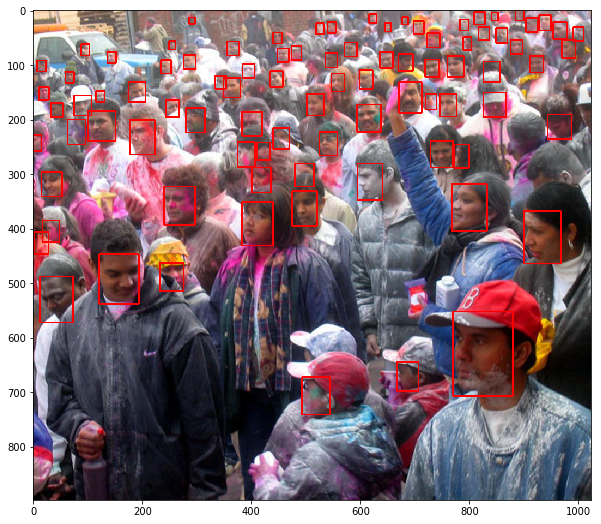

In [45]:
idx = 92
img = cv2.imread(glob.glob(data_dir + '*')[idx])
for i in range(len(b[idx])):
    bbox = b[idx][i]
    cv2.rectangle(img, (bbox[0], bbox[1]),
                  (bbox[2], bbox[3]),  (0, 0, 255), 2)
f, ax = plt.subplots(figsize=(10,10))
ax.imshow(img[:,:,::-1])

## HOG 
**!! Use TensorFlow Kernel !!** (or any kernel with dlib) 

In [15]:
import dlib

In [32]:
# Create a HOG face detector using the built-in dlib class
face_detector = dlib.get_frontal_face_detector()

# Loop over images for detection
b = []
tic = time.time()
for img_path in glob.glob(data_dir + '*'):
    img = cv2.imread(img_path)
    detected_faces = face_detector(img)
    b.append([(k.left(), k.top(), k.right(), k.bottom()) for k in detected_faces])
toc = time.time()
print('It took %.1f sec' % (toc-tic))

It took 9 sec


In [34]:
a, df = compute_stats(data_dir, d, b)

In [37]:
print('%d/%d (%.2f) bounding boxes found over all images of the folder\n\
Mean Jaccard : %.2f' % (df.Nb_Pred_Bboxes.sum(),
       df.Nb_Truth_Bboxes.sum(), df.Nb_Pred_Bboxes.sum() / df.Nb_Truth_Bboxes.sum(),
       df.mJaccard.mean()))

76/3948 (0.02) bounding boxes found over all images of the folder
Mean Jaccard : 0.66


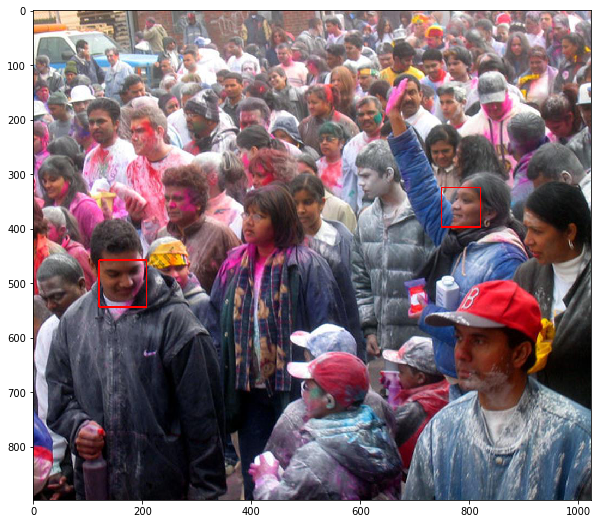

In [39]:
idx = 92
img = cv2.imread(glob.glob(data_dir + '*')[idx])
for i in range(len(b[idx])):
    bbox = b[idx][i]
    cv2.rectangle(img, (bbox[0], bbox[1]),
                  (bbox[2], bbox[3]),  (0, 0, 255), 2)
f, ax = plt.subplots(figsize=(10,10))
ax.imshow(img[:,:,::-1])

## Haar Cascades

In [52]:
img = cv2.imread(glob.glob(data_dir + '*')[idx])
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [62]:
#load cascade classifier training file for haarcascade 
haar_face_cascade = cv2.CascadeClassifier('/usr/share/opencv/haarcascades/haarcascade_frontalface_alt.xml')

In [69]:
faces = haar_face_cascade.detectMultiScale(gray_img)

In [71]:
#load cascade classifier training file for haarcascade 
haar_face_cascade = cv2.CascadeClassifier('/usr/share/opencv/haarcascades/haarcascade_frontalface_alt.xml')

# Loop over images for detection
b = []
tic = time.time()
for img_path in glob.glob(data_dir + '*'):
    img = cv2.imread(img_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = haar_face_cascade.detectMultiScale(gray_img)
    b.append([(x, y, x+w, y+h) for (x, y, w, h) in faces])
toc = time.time()
print('It took %.1f sec' % (toc-tic))

It took 18.3 sec


In [72]:
a, df = compute_stats(data_dir, d, b)

In [73]:
print('%d/%d (%.2f) bounding boxes found over all images of the folder\n\
Mean Jaccard : %.2f' % (df.Nb_Pred_Bboxes.sum(),
       df.Nb_Truth_Bboxes.sum(), df.Nb_Pred_Bboxes.sum() / df.Nb_Truth_Bboxes.sum(),
       df.mJaccard.mean()))

401/3948 (0.10) bounding boxes found over all images of the folder
Mean Jaccard : 0.69


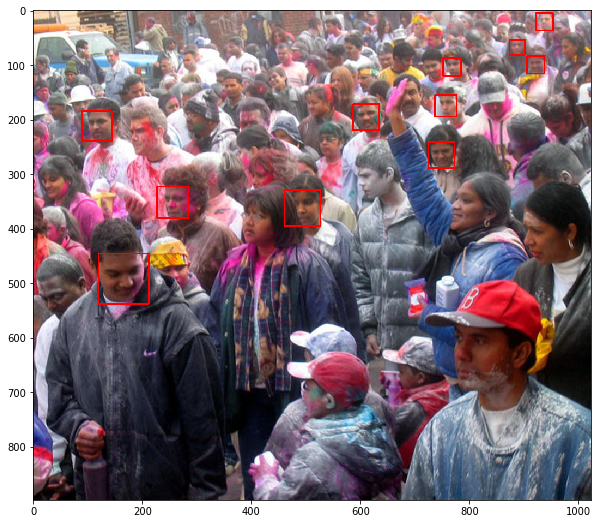

In [74]:
idx = 92
img = cv2.imread(glob.glob(data_dir + '*')[idx])
for i in range(len(b[idx])):
    bbox = b[idx][i]
    cv2.rectangle(img, (bbox[0], bbox[1]),
                  (bbox[2], bbox[3]),  (0, 0, 255), 2)
f, ax = plt.subplots(figsize=(10,10))
ax.imshow(img[:,:,::-1])

## Extensions

See [Face R-CNN](https://arxiv.org/pdf/1706.01061.pdf) for an improved Faster R-CNN for Faces published recently that can probably outperform with Tiny Faces :   
Results comparison [here](http://vis-www.cs.umass.edu/fddb/results.html)